# Q2 Image Segmentation

## 1.

In [2]:
import torch
import torchvision
from PIL import Image
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wandb
import random
import os
import cv2

In [13]:
# !pip install wandb
# device check cuda

cuda:0


In [2]:
training_images=[]
training_masks=[]
for directory in os.listdir("VOC Segmentation Dataset/"):
    print(directory)
    for image in os.listdir("VOC Segmentation Dataset/"+directory+"/"):
        if image.endswith(".jpg"):
            training_images.append(cv2.cvtColor(cv2.imread("VOC Segmentation Dataset/"+directory+"/"+image), cv2.COLOR_BGR2RGB))
        if image.endswith(".png"):
            training_masks.append(cv2.cvtColor(cv2.imread("VOC Segmentation Dataset/"+directory+"/"+image), cv2.COLOR_BGR2RGB))

images
masks


In [3]:
training_data=list(zip(training_images, training_masks))
traain_size=int(len(training_data)*0.7)
vaal_size=int(len(training_data)*0.2)
teest_size=len(training_data)-traain_size-vaal_size
train_data,val_data,test_data=torch.utils.data.random_split(training_data, [traain_size,vaal_size,teest_size], generator=torch.Generator().manual_seed(42))
print(len(train_data), len(val_data), len(test_data))

1024 292 148


In [18]:
wandb.init(project="CV_assignment1_Q2")

loss,▁▂▃▅▅▇▃█▄▅▃▃▂▄▃▆▅▆▇▆▅▇▄▄▃▅▅▄▅▇▃▄▃▃▅▄▄▄▃▃
loss,1.53918


In [4]:
transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])    
    ])

In [5]:
cmap=[
    (0,0,0),
    (128,0,0),
    (0,128,0),
    (128,128,0),
    (0,0,128),
    (128,0,128),    
    (0,128,128),
    (128,128,128),
    (64,0,0),
    (192,0,0),
    (64,128,0),
    (192,128,0),
    (64,0,128),
    (192,0,128),
    (64,128,128),
    (192,128,128),
    (0,64,0),
    (128,64,0),
    (0,192,0),
    (128,192,0),
    (0,64,128)
]

In [21]:
class custom(Dataset):
    def __init__(self, image,mask,train,transform=None):
        self.transform=transform
        self.train=train
        if self.train=="train":
            self.image=image[:int(len(image)*0.7)]
            self.mask=mask[:int(len(mask)*0.7)]
        elif self.train=="val":
            self.image=image[int(len(image)*0.7):int(len(image)*0.9)]
            self.mask=mask[int(len(mask)*0.7):int(len(mask)*0.9)]
        elif self.train=="test":
            self.image=image[int(len(image)*0.9):]
            self.mask=mask[int(len(mask)*0.9):]
    def __len__(self):
        return len(self.image)
    def __getitem__(self, idx):
        img=self.image[idx]
        mask=self.mask[idx]
        if img.shape[0]<256:
            padding=np.zeros((256-img.shape[0],img.shape[1],img.shape[2]))
            img=np.concatenate((img,padding),axis=0)
            mask=np.concatenate((mask,padding),axis=0)
        if img.shape[1]<256:
            padding=np.zeros((img.shape[0],256-img.shape[1],img.shape[2]))
            img=np.concatenate((img,padding),axis=1)
            mask=np.concatenate((mask,padding),axis=1)
        height,width=img.shape[0],img.shape[1]
        upper=random.randint(0,height-256)
        left=random.randint(0,width-256)
        img=img[upper:upper+256,left:left+256]
        mask=mask[upper:upper+256,left:left+256]
        img=img.astype(np.double)
        mask=mask.astype(np.double)
        if self.transform:
            img=self.transform(img)
        lab=np.zeros((256,256))
        for i,color in enumerate(cmap):
            lab[(mask==color).all(axis=2)]=i
        return img,lab

In [22]:
train_custom=custom(training_images,training_masks,train="train",transform=transform)
val_custom=custom(training_images,training_masks,train="val",transform=transform)
test_custom=custom(training_images,training_masks,train="test",transform=transform)

In [23]:
train_loader=DataLoader(train_custom,batch_size=4,shuffle=True)
val_loader=DataLoader(val_custom,batch_size=4,shuffle=True)
test_loader=DataLoader(test_custom,batch_size=4,shuffle=True)

In [10]:
comap={
    "12800":"aeroplane",
    "01280":"bicycle",
    "1281280":"bird",
    "00128":"boat",
    "1280128":"bottle",
    "0128128":"bus",
    "128128128":"car",
    "6400":"cat",
    "19200":"chair",
    "641280":"cow",
    "1921280":"dining_table",
    "640128":"dog",
    "1920128":"horse",
    "64128128":"motorbike",
    "192128128":"person",
    "0640":"potted_plant",
    "128640":"sheep",
    "01920":"sofa",
    "1281920":"train",
    "064128":"tv_monitor"
}
train_count={
    "aeroplane":0,
    "bicycle":0,
    "bird":0,
    "boat":0,
    "bottle":0,
    "bus":0,
    "car":0,
    "cat":0,
    "chair":0,
    "cow":0,
    "dining_table":0,
    "dog":0,
    "horse":0,
    "motorbike":0,
    "person":0,
    "potted_plant":0,
    "sheep":0,
    "sofa":0,
    "train":0,
    "tv_monitor":0
}
import copy
val_count=copy.deepcopy(train_count)
test_count=copy.deepcopy(train_count)
train_data_list=[]
val_data_list=[]
test_data_list=[]
train_mask_list=[]
val_mask_list=[]
test_mask_list=[]
for i in range(len(train_data)):
    train_data_list.append(train_data[i][0])
    train_mask_list.append(train_data[i][1])
for i in range(len(val_data)):
    val_data_list.append(val_data[i][0])
    val_mask_list.append(val_data[i][1])
for i in range(len(test_data)):
    test_data_list.append(test_data[i][0])
    test_mask_list.append(test_data[i][1])

In [19]:
comap_keys=set(comap.keys())
for i in range(len(train_mask_list)):
    check=set()
    for j in range(len(train_mask_list[i])):
        for r,g,b in train_mask_list[i][j]:
            temp=str(r)+str(g)+str(b)
            if temp not in check and temp in comap_keys:
                check.add(temp)
                train_count[comap[temp]]+=1

{'aeroplane': 59, 'bicycle': 51, 'bird': 70, 'boat': 60, 'bottle': 61, 'bus': 53, 'car': 92, 'cat': 86, 'chair': 96, 'cow': 50, 'dining_table': 51, 'dog': 89, 'horse': 47, 'motorbike': 62, 'person': 324, 'potted_plant': 56, 'sheep': 43, 'sofa': 66, 'train': 57, 'tv_monitor': 56}


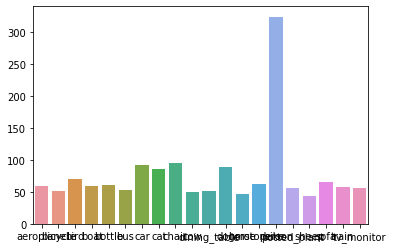

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
print(train_count)
sns.barplot(x=list(train_count.keys()),y=list(train_count.values()))
plt.show()

{'aeroplane': 19, 'bicycle': 8, 'bird': 21, 'boat': 13, 'bottle': 18, 'bus': 19, 'car': 24, 'cat': 27, 'chair': 37, 'cow': 8, 'dining_table': 18, 'dog': 24, 'horse': 12, 'motorbike': 16, 'person': 75, 'potted_plant': 19, 'sheep': 12, 'sofa': 19, 'train': 17, 'tv_monitor': 22}


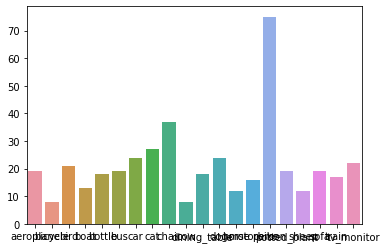

In [21]:
for i in range(len(val_mask_list)):
    check=set()
    for j in range(len(val_mask_list[i])):
        for r,g,b in val_mask_list[i][j]:
            temp=str(r)+str(g)+str(b)
            if temp not in check and temp in comap_keys:
                check.add(temp)
                val_count[comap[temp]]+=1
print(val_count)
sns.barplot(x=list(val_count.keys()),y=list(val_count.values()))
plt.show()

In [24]:
model=torchvision.models.segmentation.fcn_resnet50(pretrained=True)
model=model.double()
model.train()
model=model.to("cuda")
criterion=nn.NLLLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)
wandb.watch(model,criterion,log="all",log_freq=10)

[]

In [26]:
from torch.autograd import Variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
for epoch in range(3):
    training_loss=0
    for i,data in enumerate(train_loader):
        im = Variable(data[0].to(device))
        label = Variable(data[1].to(device))
        img=img.to("cuda")
        lab=lab.to("cuda")
        optimizer.zero_grad()
        output=model(img)['out']
        output=F.log_softmax(output,dim=1)
        loss=criterion(output,lab.type(torch.long))
        loss.backward()
        optimizer.step()
        wandb.log({"loss":loss.item()})
        training_loss+=loss.item()
    print("Epoch: ",epoch," Loss: ",training_loss/len(val_loader))

Epoch:  0  Loss:  0.0837076958753746
Epoch:  1  Loss:  0.0155444822342331
Epoch:  2  Loss:  0.011991728626011184


In [4]:
class_dic={
    0:"background",
    1:"aeroplane",
    2:"bicycle",
    3:"bird",
    4:"boat",
    5:"bottle",
    6:"bus",
    7:"car",
    8:"cat",
    9:"chair",
    10:"cow",
    11:"dining_table",
    12:"dog",
    13:"horse",
    14:"motorbike",
    15:"person",
    16:"potted_plant",
    17:"sheep",
    18:"sofa",
    19:"train",
    20:"tv_monitor"
}
conf=np.zeros((21,21))
classwise_pixel_accuracy=[0]*21
classwise_total_pixels=[0]*21

In [5]:
for i,data in enumerate(test_loader,0):
    img,lab=data
    if img.shape[0]!=4:
        continue
    img=img.to("cuda")
    lab=lab.to("cuda")
    output=model(img)['out']
    output=torch.argmax(F.log_softmax(output,dim=1),dim=1)
    for j in range(4):
        for k in range(256):
            for l in range(256):
                classwise_total_pixels[int(lab[j,k,l])]+=1
                if int(lab[j,k,l])==int(output[j,k,l]):
                    classwise_pixel_accuracy[int(lab[j,k,l])]+=1
                conf[int(lab[j,k,l]),int(output[j,k,l])]+=1
for i in range(len(classwise_pixel_accuracy)):
    classwise_pixel_accuracy[i]/=(classwise_total_pixels[i]+1e-16)
    print("Class: ",class_dic[i]," Pixel Accuracy: ",classwise_pixel_accuracy[i])
    prec=conf[i,i]/(np.sum(conf[:,i])+1e-16)
    print("Precision: ",prec)
    rec=conf[i,i]/(np.sum(conf[i,:])+1e-16)
    print("Recall: ",rec)
    print("F1 Score",2*prec*rec/(prec+rec+1e-16))
    print("IOU: ",conf[i,i]/(np.sum(conf[:,i])+np.sum(conf[i,:])-conf[i,i]+1e-16))
print("Mean Pixel Accuracy: ",np.mean(classwise_pixel_accuracy))
print("Average Precision: ",np.sum(conf.diagonal())/(np.sum(conf)+1e-16))


Class:  background  Pixel Accuracy:  0.97248468
Precision:  0.9791269
Recall:  0.97801924
F1 Score 0.9785727565561926
IOU:  0.93472364
Class:  aeroplane  Pixel Accuracy:  0.98932576
Precision:  0.936456256
Recall:  0.93296261
F1 Score 0.93470616846614
IOU:  0.87981064
Class:  bicycle  Pixel Accuracy:  0.93410423
Precision:  0.68426865
Recall:  0.74059241
F1 Score 0.7113173106028268
IOU:  0.57467678
Class:  bird  Pixel Accuracy:  0.98592363
Precision:  0.94903613
Recall:  0.941883502
F1 Score 0.9454462881677111
IOU:  0.86704528
Class:  boat  Pixel Accuracy:  0.98928289
Precision:  0.92832337
Recall:  0.93471458
F1 Score 0.931508012377026
IOU:  0.85869137
Class:  bottle  Pixel Accuracy:  0.98284626
Precision:  0.93725125
Recall:  0.9255691
F1 Score 0.9313735443531901
IOU:  0.88924568
Class:  bus  Pixel Accuracy:  0.98426413
Precision:  0.98131566
Recall:  0.99156374
F1 Score 0.9864130832834166
IOU:  0.97924048
Class:  car  Pixel Accuracy:  0.97354311
Precision:  0.9807132
Recall:  0.8466

# 1.3

In [6]:
class custom_aug(Dataset):
    def __init__(self, image,mask,train,transform=None):
        self.transform=transform
        self.train=train
        if self.train=="train":
            self.image=image[:int(len(image)*0.7)]
            self.mask=mask[:int(len(mask)*0.7)]
        elif self.train=="val":
            self.image=image[int(len(image)*0.7):int(len(image)*0.9)]
            self.mask=mask[int(len(mask)*0.7):int(len(mask)*0.9)]
        elif self.train=="test":
            self.image=image[int(len(image)*0.9):]
            self.mask=mask[int(len(mask)*0.9):]
    def __len__(self):
        return len(self.image)
    def __getitem__(self, idx):
        img=self.image[idx]
        mask=self.mask[idx]
        if img.shape[0]<256:
            padding=np.zeros((256-img.shape[0],img.shape[1],img.shape[2]))
            img=np.concatenate((img,padding),axis=0)
            mask=np.concatenate((mask,padding),axis=0)
        if img.shape[1]<256:
            padding=np.zeros((img.shape[0],256-img.shape[1],img.shape[2]))
            img=np.concatenate((img,padding),axis=1)
            mask=np.concatenate((mask,padding),axis=1)
        height,width=img.shape[0],img.shape[1]
        upper=random.randint(0,height-256)
        left=random.randint(0,width-256)
        img=img[upper:upper+256,left:left+256]
        mask=mask[upper:upper+256,left:left+256]
        img=img.astype(np.double)
        mask=mask.astype(np.double)
        if self.train=="train":
            randr=random.random()
            randg=random.random()
            if randr>=0.5:
                img=cv2.flip(img,1)
                mask=cv2.flip(mask,1)
            if randg>=0.5:
                ang=random.randint(-10,10)
                height,width=img.shape[0],img.shape[1]
                rotn=cv2.getRotationMatrix2D((width/2,height/2),ang,1)
                img=cv2.warpAffine(img,rotn,(width,height))
                mask=cv2.warpAffine(mask,rotn,(width,height))
        if self.transform:
            img=self.transform(img)
        lab=np.zeros((256,256))
        for i,color in enumerate(cmap):
            lab[(mask==color).all(axis=2)]=i
        return img,lab

In [7]:
train_aug=custom_aug(training_images,training_masks,"train",transform=transform)
val_aug=custom_aug(training_images,training_masks,"val",transform=transform)
test_aug=custom_aug(training_images,training_masks,"test",transform=transform)

train_loader=DataLoader(train_aug,batch_size=4,shuffle=True)
val_loader=DataLoader(val_aug,batch_size=4,shuffle=True)
test_loader=DataLoader(test_aug,batch_size=4,shuffle=True)

In [8]:
model=torchvision.models.segmentation.fcn_resnet50(pretrained=True)
model=model.double()
model=model.to("cuda")
model.train()
criterion=nn.NLLLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)


c:\Users\Vibhor\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Vibhor\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
wandb.init(project="CV_assignment1_Q2")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sahil20326. Use `wandb login --relogin` to force relogin


In [7]:
for epoch in range(3):
    training_loss=0
    for i,data in enumerate(train_loader,0):
        img,lab=data
        if img.shape[0]!=4:
            continue
        img=img.to("cuda")
        lab=lab.to("cuda")
        optimizer.zero_grad()
        output=model(img)['out']
        output=F.log_softmax(output,dim=1)
        loss=criterion(output,lab.type(torch.long))
        loss.backward()
        optimizer.step()
        wandb.log({"loss":loss.item()})
        training_loss+=loss.item()
    print("Epoch: ",epoch," Loss: ",training_loss/len(val_loader))

Epoch:  0  Loss:  0.19637889024190591
Epoch:  1  Loss:  0.1660757751903744
Epoch:  2  Loss:  0.16600251999396214


In [6]:
classwise_pixel_accuracy=[0]*21
classwise_total_pixels=[0]*21
conf=np.zeros((21,21))
for i,data in enumerate(test_loader,0):
    img,lab=data
    if img.shape[0]!=4:
        continue
    img=img.to("cuda")
    lab=lab.to("cuda")
    output=model(img)['out']
    output=torch.argmax(F.log_softmax(output,dim=1),dim=1)
    for j in range(4):
        for k in range(256):
            for l in range(256):
                classwise_total_pixels[int(lab[j,k,l])]+=1
                if int(lab[j,k,l])==int(output[j,k,l]):
                    classwise_pixel_accuracy[int(lab[j,k,l])]+=1
                conf[int(lab[j,k,l]),int(output[j,k,l])]+=1
for i in range(21):
    print("Class: ",i)
    print("Pixel Accuracy: ",classwise_pixel_accuracy[i]/(1e-16+classwise_total_pixels[i]))
    prec=conf[i,i]/(np.sum(conf[:,i])+1e-16)
    print("Precision: ",prec)
    rec=conf[i,i]/(1e-16+np.sum(conf[i,:]))
    print("Recall: ",rec)
    print("F1 Score",2*prec*rec/(1e-16+prec+rec))
    print("IOU: ",conf[i,i]/(np.sum(conf[:,i])+np.sum(conf[i,:])-conf[i,i]+1e-16))
print("Mean Pixel Accuracy: ",np.mean(classwise_pixel_accuracy))
print("Average Precision: ",np.sum(conf.diagonal())/(1e-16+np.sum(conf)))

Class:  background
Pixel Accuracy:  0.93874191
Precision:  0.97319174
Recall:  0.96702663
F1 Score 0.9700993900764234
IOU:  0.93672047
Class:  aeroplane
Pixel Accuracy:  0.94131644
Precision:  0.94183562
Recall:  0.81752891
F1 Score 0.8752908617724312
IOU:  0.74724368
Class:  bicycle
Pixel Accuracy:  0.77944105
Precision:  0.75982341
Recall:  0.95215905
F1 Score 0.8451870893973534
IOU:  0.701024289
Class:  bird
Pixel Accuracy:  0.96861405
Precision:  0.90574608
Recall:  0.8771843
F1 Score 0.8912364162671836
IOU:  0.79372144
Class:  boat
Pixel Accuracy:  0.96182681
Precision:  0.90313571
Recall:  0.85205136
F1 Score 0.876850135376243
IOU:  0.78689414
Class:  bottle
Pixel Accuracy:  0.97814234
Precision:  0.94209374
Recall:  0.95355611
F1 Score 0.94779027041281
IOU:  0.88786517
Class:  bus
Pixel Accuracy:  0.9583311
Precision:  0.9621419
Recall:  0.96614589
F1 Score 0.9641397379607853
IOU:  0.91487375
Class:  car
Pixel Accuracy:  0.97224179
Precision:  0.93619322
Recall:  0.9162362
F1 Sc